In [68]:
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler   # better for LSTMs
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [69]:
data = pd.read_csv('MicrosoftStock.csv')
data.head()

,index,date,open,high,low,close,volume,Name
0,390198,2013-02-08,27.35,27.71,27.31,27.55,33318306,MSFT
1,390199,2013-02-11,27.65,27.92,27.50,27.86,32247549,MSFT
2,390200,2013-02-12,27.88,28.00,27.75,27.88,35990829,MSFT
3,390201,2013-02-13,27.93,28.11,27.88,28.03,41715530,MSFT
4,390202,2013-02-14,27.92,28.06,27.87,28.04,32663174,MSFT


In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   1259 non-null   int64  
 1   date    1259 non-null   object 
 2   open    1259 non-null   float64
 3   high    1259 non-null   float64
 4   low     1259 non-null   float64
 5   close   1259 non-null   float64
 6   volume  1259 non-null   int64  
 7   Name    1259 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 78.8+ KB


In [71]:
data.describe()

,index,open,high,low,close,volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,390827.000000,51.026394,51.436007,50.630397,51.063081,3.386946e+07
std,363.586303,14.859387,14.930144,14.774630,14.852117,1.958979e+07
min,390198.000000,27.350000,27.600000,27.230000,27.370000,7.425603e+06
25%,390512.500000,40.305000,40.637500,39.870000,40.310000,2.254879e+07
50%,390827.000000,47.440000,47.810000,47.005000,47.520000,2.938758e+07
75%,391141.500000,59.955000,60.435000,59.275000,59.730000,3.842024e+07
max,391456.000000,95.140000,96.070000,93.720000,95.010000,2.483542e+08


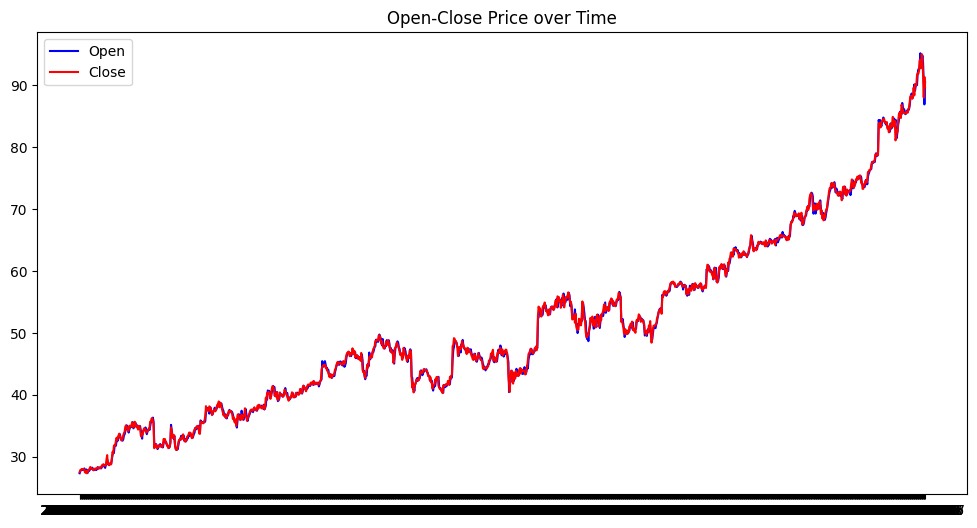

In [72]:
# open and close prices of time
plt.figure(figsize=(12,6))
plt.plot(data['date'], data['open'], label="Open", color='blue')
plt.plot(data['date'], data['close'], label="Close", color='red')
plt.title("Open-Close Price over Time")
plt.legend()
plt.show()

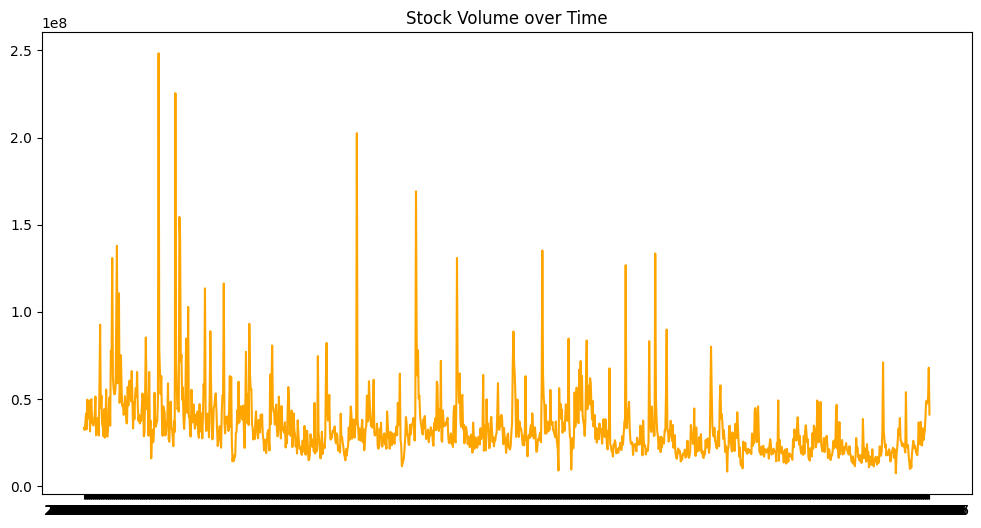

In [73]:
# trading volume (check for outliers)
plt.figure(figsize=(12,6))
plt.plot(data['date'], data['volume'], label='Volume', color='orange')
plt.title('Stock Volume over Time')
plt.show()

In [76]:
# drop non-numeric cols
num_data = data.select_dtypes(include=['int64', 'float64'])

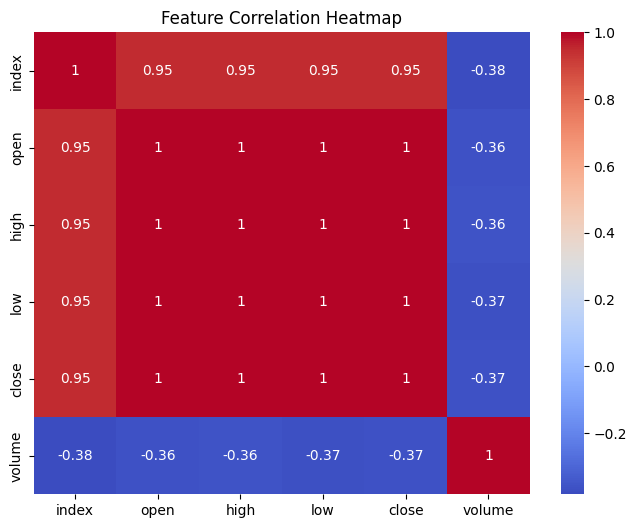

In [75]:
# check for correlation between features
plt.figure(figsize=(8,6))
sns.heatmap(num_data.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [77]:
# convert the data to datetime
data['date'] = pd.to_datetime(data['date'])

In [78]:
# create date filter (date range, optional)
prediction = data.loc[
    (data['date'] > datetime(2013, 1, 1)) &
    (data['date'] < datetime(2018, 1, 1))
]

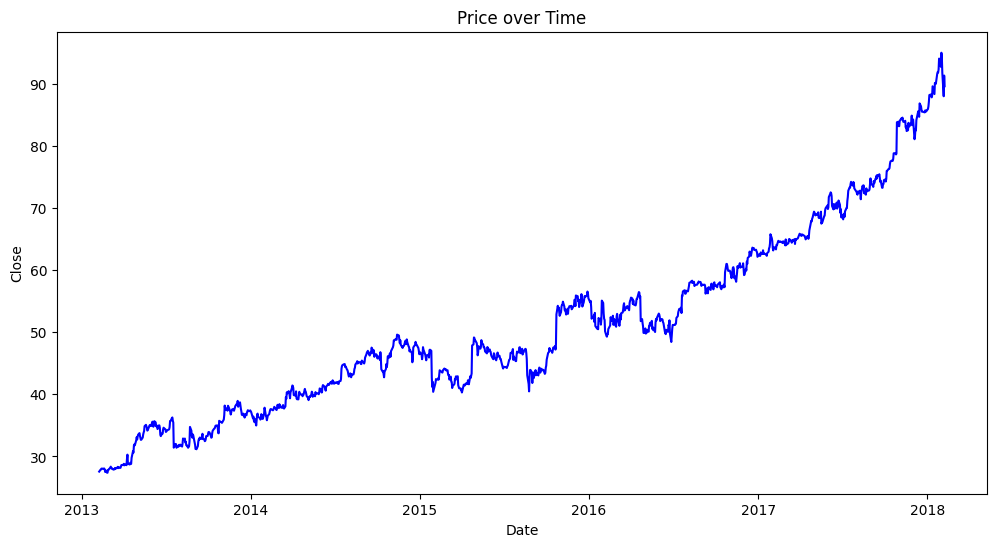

In [79]:
plt.figure(figsize=(12,6))
plt.plot(data['date'], data['close'], color='blue')
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Price over Time')
plt.show()

lstm model (sequential)

In [80]:
# use closing price only
stock_close = data['close'].values

In [81]:
# train/test split
training_data_len = int(np.ceil(len(stock_close) * 0.95))
train_data = stock_close[:training_data_len].reshape(-1, 1)
test_data = stock_close[training_data_len:].reshape(-1, 1)

In [83]:
# preprocessing
# scale data
scaler = MinMaxScaler(feature_range=(0, 1))  

In [84]:
# fit only on training data
scaler.fit(train_data)

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [85]:
# transform both train and test data
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [86]:
X_train, y_train = [], []

In [87]:
# create a sliding window for the stock (60 days)
for i in range(60, len(train_scaled)):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i, 0])

In [88]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [89]:
# reshape for LSTM [samples, timesteps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [90]:
# build model
model = keras.models.Sequential()

# first layer
model.add(layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1],1)))
# second layer
model.add(layers.LSTM(64, return_sequences=False))
# third layer
model.add(layers.Dense(128, activation='relu'))
# fourth layer (dropout)
model.add(layers.Dropout(0.5))
# final output layer
model.add(layers.Dense(1))

model.summary()
model.compile(optimizer='adam',
              loss='mae',
              metrics=[keras.metrics.RootMeanSquaredError()])

c:\Users\Jay-ann Alorro\Documents\CPE029\LSTM_Microsoft_Stock\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

In [92]:
# training the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0405 - root_mean_squared_error: 0.0570
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0363 - root_mean_squared_error: 0.0519
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0374 - root_mean_squared_error: 0.0537
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0351 - root_mean_squared_error: 0.0509
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0382 - root_mean_squared_error: 0.0543
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0339 - root_mean_squared_error: 0.0485
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0356 - root_mean_squared_error: 0.0519
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0335 - root_mean_squared_error: 0.0473
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0329 - root_mean_squared_error: 0.0472
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0340 - root_mean_squared_error: 0.0489

In [93]:
# test data
X_test, y_test = [], test_scaled[60:]

In [94]:
for i in range(60, len(test_scaled)):
    X_test.append(test_scaled[i-60:i, 0])

In [95]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [96]:
# making prediction
pred = model.predict(X_test)
pred = scaler.inverse_transform(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


In [97]:
# align predictions with test set
test = data[training_data_len:].copy()
test['Predictions'] = np.nan
test.iloc[60:, test.columns.get_loc('Predictions')] = pred.flatten()

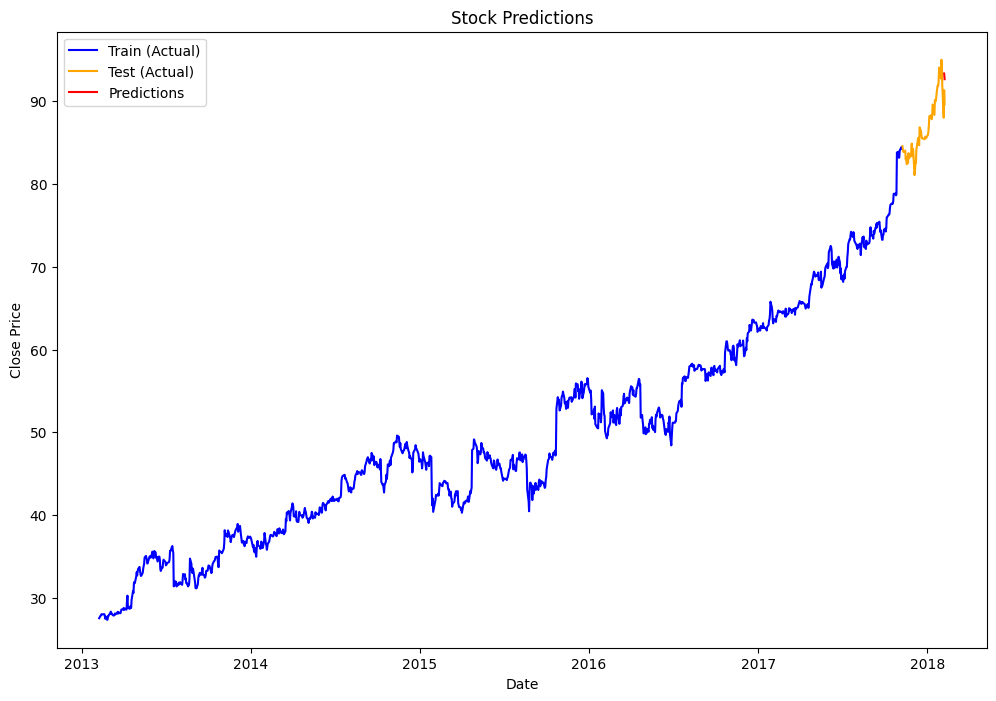

In [99]:
# plotting data
train = data[:training_data_len]

plt.figure(figsize=(12, 8))
plt.plot(train['date'], train['close'], label='Train (Actual)', color='blue')
plt.plot(test['date'], test['close'], label='Test (Actual)', color='orange')
plt.plot(test['date'], test['Predictions'], label='Predictions', color='red')
plt.title('Stock Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [100]:
# evaluation
rmse = np.sqrt(mean_squared_error(test['close'][60:], test['Predictions'][60:]))
mae = mean_absolute_error(test['close'][60:], test['Predictions'][60:])
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 2.59
MAE: 2.53
